Số lượng classes: 7
Classes: {0: 'warning', 1: 'no parking/waiting', 2: 'other prohibition signs', 3: 'no entry', 4: 'mandatory', 5: 'max speed', 6: 'no turning'}
📊 THỐNG KÊ DATASET
Train images: 0
Val images: 0
Test images: 0
Total: 0

📈 PHÂN BỐ CLASSES:
                     Class  Train  Val
0                  warning      0    0
1       no parking/waiting      0    0
2  other prohibition signs      0    0
3                 no entry      0    0
4                mandatory      0    0
5                max speed      0    0
6               no turning      0    0


FileNotFoundError: [Errno 2] No such file or directory: '../docs/class_distribution.png'

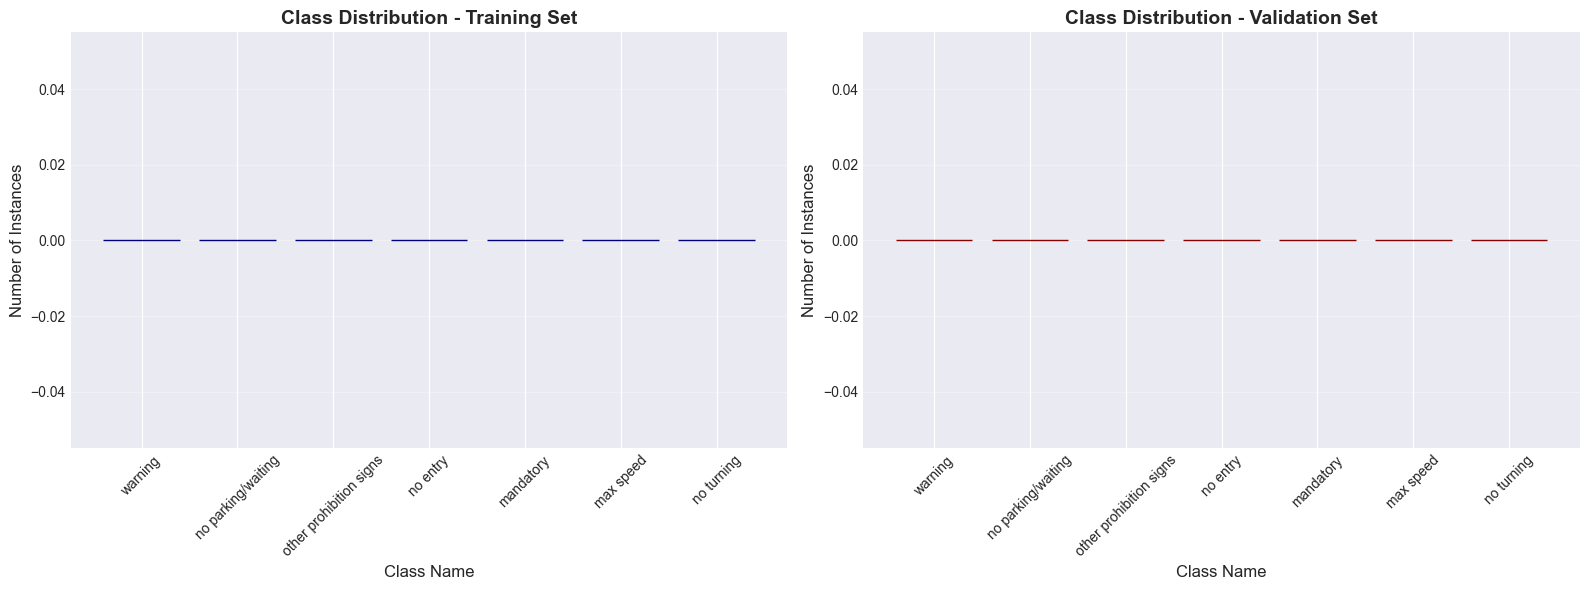

In [ ]:
# %% [markdown]
# # 📊 EDA and Data Preparation - Zalo Traffic Sign Dataset
# **Data Lead: [Tên Bạn]**  
# **Date: 2025-11-01**
# 
# ## Mục tiêu:
# 1. Phân tích dataset gốc (COCO format)
# 2. Convert sang YOLO format
# 3. Split dataset: Train/Val/Test
# 4. Thống kê và trực quan hóa dữ liệu
# 5. Xuất báo cáo EDA

# %% [markdown]
# ## 1️⃣ Import Libraries

# %%
import os
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import yaml
import warnings
warnings.filterwarnings('ignore')

# Cấu hình plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")

# %% [markdown]
# ## 2️⃣ Load và Khám Phá Dataset Gốc

# %%
# Đọc file annotations CSV
df = pd.read_csv('../data/annotations.csv')

print("📊 THÔNG TIN DATASET GỐC")
print("=" * 60)
print(f"Tổng số annotations: {len(df):,}")
print(f"Tổng số ảnh unique: {df['file_name'].nunique():,}")
print(f"Tổng số classes: {df['category_id'].nunique()}")
print("\n📋 Columns trong dataset:")
print(df.columns.tolist())
print("\n🔍 Sample data (5 dòng đầu):")
df.head()

# %%
# Thống kê cơ bản
print("\n📈 THỐNG KÊ THEO CLASS")
print("=" * 60)
class_stats = df.groupby(['category_id', 'supercategory']).agg({
    'box_id': 'count',
    'area': ['mean', 'std', 'min', 'max']
}).round(2)
class_stats.columns = ['Count', 'Mean_Area', 'Std_Area', 'Min_Area', 'Max_Area']
print(class_stats)

# %%
# Thống kê kích thước ảnh
print("\n📐 THỐNG KÊ KÍCH THƯỚC ẢNH")
print("=" * 60)
img_sizes = df[['file_name', 'width', 'height']].drop_duplicates()
print(f"Unique image sizes: {img_sizes[['width', 'height']].drop_duplicates().values.tolist()}")
print(f"Chiều rộng: {img_sizes['width'].unique()}")
print(f"Chiều cao: {img_sizes['height'].unique()}")

# %% [markdown]
# ## 3️⃣ Chuẩn Bị Class Mapping

# %%
# Lấy danh sách classes từ dataset
unique_classes = df[['category_id', 'supercategory']].drop_duplicates().sort_values('category_id')

print("📝 ORIGINAL CLASS MAPPING FROM ZALO")
print("=" * 60)
print(unique_classes.to_string(index=False))

# Mapping từ category_id gốc sang YOLO class ID (0-6) và tên tiếng Anh
# Theo thứ tự: category_id -> (yolo_class_id, english_name)
category_to_yolo = {
    2: (0, 'warning'),
    1: (1, 'no parking/waiting'),
    3: (2, 'other prohibition signs'),
    4: (3, 'no entry'),
    5: (4, 'mandatory'),
    6: (5, 'max speed'),
    7: (6, 'no turning')
}

# Tạo YOLO class names dictionary (0-6)
class_names = {yolo_id: eng_name for _, (yolo_id, eng_name) in category_to_yolo.items()}
num_classes = len(class_names)

# Add yolo_class_id to dataframe
df['yolo_class_id'] = df['category_id'].map(lambda x: category_to_yolo.get(x, (x, 'unknown'))[0])
df['class_name_en'] = df['category_id'].map(lambda x: category_to_yolo.get(x, (x, 'unknown'))[1])

print(f"\n📝 YOLO CLASS MAPPING (for training)")
print("=" * 60)
for yolo_id in sorted(class_names.keys()):
    print(f"  {yolo_id}: {class_names[yolo_id]}")

print(f"\n✅ Total classes: {num_classes}")

# %% [markdown]
# ## 4️⃣ Split Dataset (Train/Val/Test)

# %%
# Lấy danh sách ảnh unique
image_files = df['file_name'].unique()
print(f"📂 Total unique images: {len(image_files)}")

# Split: 70% train, 20% val, 10% test
train_imgs, temp_imgs = train_test_split(
    image_files, test_size=0.3, random_state=42, shuffle=True
)
val_imgs, test_imgs = train_test_split(
    temp_imgs, test_size=0.33, random_state=42, shuffle=True
)

print(f"\n📊 DATASET SPLIT")
print("=" * 60)
print(f"🟦 Train: {len(train_imgs):,} images ({len(train_imgs)/len(image_files)*100:.1f}%)")
print(f"🟨 Val:   {len(val_imgs):,} images ({len(val_imgs)/len(image_files)*100:.1f}%)")
print(f"🟥 Test:  {len(test_imgs):,} images ({len(test_imgs)/len(image_files)*100:.1f}%)")

# Tạo dictionary để mapping
split_dict = {}
for img in train_imgs:
    split_dict[img] = 'train'
for img in val_imgs:
    split_dict[img] = 'val'
for img in test_imgs:
    split_dict[img] = 'test'

df['split'] = df['file_name'].map(split_dict)

# %% [markdown]
# ## 5️⃣ Convert COCO Format → YOLO Format

# %%
def convert_bbox_to_yolo(bbox_str, img_width, img_height):
    """
    Convert COCO bbox [x_min, y_min, width, height] 
    to YOLO format [x_center, y_center, width, height] (normalized)
    """
    bbox = json.loads(bbox_str)
    x_min, y_min, bbox_width, bbox_height = bbox
    
    # Calculate center
    x_center = (x_min + bbox_width / 2) / img_width
    y_center = (y_min + bbox_height / 2) / img_height
    
    # Normalize width and height
    norm_width = bbox_width / img_width
    norm_height = bbox_height / img_height
    
    return x_center, y_center, norm_width, norm_height

# Tạo thư mục output
for split in ['train', 'val', 'test']:
    Path(f'../data/images/{split}').mkdir(parents=True, exist_ok=True)
    Path(f'../data/labels/{split}').mkdir(parents=True, exist_ok=True)

print("🔄 Converting annotations to YOLO format...")
print("=" * 60)

conversion_stats = {'train': 0, 'val': 0, 'test': 0}

for split in ['train', 'val', 'test']:
    split_df = df[df['split'] == split]
    
    for image_file, group in split_df.groupby('file_name'):
        img_width = group.iloc[0]['width']
        img_height = group.iloc[0]['height']
        
        # Tạo file .txt label
        label_file = Path(f'../data/labels/{split}') / f"{Path(image_file).stem}.txt"
        
        with open(label_file, 'w') as f:
            for _, row in group.iterrows():
                # Convert category_id từ Zalo sang YOLO class_id (0-6)
                yolo_class_id = row['yolo_class_id']
                x_c, y_c, w, h = convert_bbox_to_yolo(
                    row['bbox'], img_width, img_height
                )
                f.write(f"{yolo_class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
        
        conversion_stats[split] += 1

print("✅ Conversion completed!")
for split, count in conversion_stats.items():
    print(f"   {split.capitalize()}: {count} label files created")

# Verify một file mẫu
sample_label = Path('../data/labels/train').glob('*.txt').__next__()
print(f"\n📝 Sample label file ({sample_label.name}):")
print(sample_label.read_text()[:200] + "...")

# %% [markdown]
# ## 6️⃣ Tạo File Config YOLO

# %%
config = {
    'path': './data',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': num_classes,
    'names': class_names  # YOLO format: {0: 'warning', 1: 'no parking/waiting', ...}
}

config_path = Path('../configs/zalo.yaml')
config_path.parent.mkdir(parents=True, exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print("✅ Config file created: configs/zalo.yaml")
print("\n📄 Config content:")
print(yaml.dump(config, default_flow_style=False))

# %% [markdown]
# ## 7️⃣ EDA - Phân Tích Phân Bố Classes

# %%
# Thống kê theo split và class
split_class_stats = df.groupby(['split', 'class_name_en']).size().unstack(fill_value=0)

# Sắp xếp lại columns theo thứ tự YOLO class ID
ordered_cols = [class_names[i] for i in sorted(class_names.keys())]
split_class_stats = split_class_stats[ordered_cols]

print("📊 CLASS DISTRIBUTION BY SPLIT")
print("=" * 80)
print(split_class_stats)
print("\n📈 Total per split:")
print(split_class_stats.sum(axis=1))
print("\n📈 Total per class:")
print(split_class_stats.sum(axis=0))

# %%
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']

for idx, split in enumerate(['train', 'val', 'test']):
    split_data = df[df['split'] == split]['class_name_en'].value_counts()
    # Sắp xếp theo thứ tự YOLO class ID
    ordered_classes = [class_names[i] for i in sorted(class_names.keys()) if class_names[i] in split_data.index]
    split_data = split_data.reindex(ordered_classes)
    
    axes[idx].bar(range(len(split_data)), split_data.values, 
                  color=colors[:len(split_data)])
    axes[idx].set_xticks(range(len(split_data)))
    axes[idx].set_xticklabels(split_data.index, rotation=45, ha='right', fontsize=9)
    axes[idx].set_title(f'{split.upper()} Set - Class Distribution', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class Name', fontsize=11)
    axes[idx].set_ylabel('Number of Instances', fontsize=11)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm số lượng lên mỗi cột
    for i, v in enumerate(split_data.values):
        axes[idx].text(i, v + max(split_data.values)*0.02, str(v), 
                      ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('../docs/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: docs/class_distribution.png")

# %%
# Class imbalance analysis
class_counts = df['class_name_en'].value_counts()
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\n⚖️ CLASS IMBALANCE ANALYSIS")
print("=" * 60)
print(f"Most common class: {class_counts.index[0]} ({max_count:,} instances)")
print(f"Least common class: {class_counts.index[-1]} ({min_count:,} instances)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 5:
    print("⚠️  High class imbalance detected!")
    print("💡 Recommendation: Use weighted loss or data augmentation")
elif imbalance_ratio > 3:
    print("⚠️  Moderate class imbalance")
    print("💡 Recommendation: Monitor per-class performance")
else:
    print("✅ Classes are relatively balanced")

# %% [markdown]
# ## 8️⃣ EDA - Phân Tích Bounding Box

# %%
# Parse bbox và tính toán metrics
df['bbox_parsed'] = df['bbox'].apply(json.loads)
df['bbox_x'] = df['bbox_parsed'].apply(lambda x: x[0])
df['bbox_y'] = df['bbox_parsed'].apply(lambda x: x[1])
df['bbox_width'] = df['bbox_parsed'].apply(lambda x: x[2])
df['bbox_height'] = df['bbox_parsed'].apply(lambda x: x[3])
df['bbox_area_pixels'] = df['bbox_width'] * df['bbox_height']

# Tính normalized metrics
df['bbox_width_norm'] = df['bbox_width'] / df['width']
df['bbox_height_norm'] = df['bbox_height'] / df['height']

print("📏 BOUNDING BOX STATISTICS (Training Set)")
print("=" * 60)
train_df = df[df['split'] == 'train']

bbox_stats = train_df[['bbox_width', 'bbox_height', 'bbox_area_pixels']].describe()
print(bbox_stats)

print(f"\n🔍 SMALL OBJECT ANALYSIS")
small_objects = train_df[train_df['bbox_area_pixels'] < 1000]
print(f"Objects < 1000px²: {len(small_objects)} ({len(small_objects)/len(train_df)*100:.1f}%)")

if len(small_objects) / len(train_df) > 0.3:
    print("⚠️  High proportion of small objects!")
    print("💡 Recommendation: Use SAHI (Slicing Aided Hyper Inference) for better detection")

# %%
# Visualize bbox distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

train_df = df[df['split'] == 'train']

# Width distribution
axes[0, 0].hist(train_df['bbox_width'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(train_df['bbox_width'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {train_df["bbox_width"].mean():.1f}px')
axes[0, 0].axvline(train_df['bbox_width'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {train_df["bbox_width"].median():.1f}px')
axes[0, 0].set_title('Bbox Width Distribution (Training)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(train_df['bbox_height'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(train_df['bbox_height'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {train_df["bbox_height"].mean():.1f}px')
axes[0, 1].axvline(train_df['bbox_height'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {train_df["bbox_height"].median():.1f}px')
axes[0, 1].set_title('Bbox Height Distribution (Training)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Area distribution (log scale)
axes[1, 0].hist(train_df['bbox_area_pixels'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(train_df['bbox_area_pixels'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {train_df["bbox_area_pixels"].mean():.0f}px²')
axes[1, 0].set_title('Bbox Area Distribution (Training)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Area (pixels²)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Width vs Height scatter
scatter = axes[1, 1].scatter(train_df['bbox_width'], train_df['bbox_height'], 
                             c=train_df['yolo_class_id'], cmap='tab10', 
                             alpha=0.5, s=20)
axes[1, 1].set_title('Bbox Width vs Height (Colored by Class)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('YOLO Class ID')

plt.tight_layout()
plt.savefig('../docs/bbox_size_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: docs/bbox_size_distribution.png")

# %% [markdown]
# ## 9️⃣ Bbox Size by Class

# %%
# Phân tích kích thước bbox theo từng class
fig, ax = plt.subplots(figsize=(14, 6))

# Lấy danh sách class names theo thứ tự YOLO class ID
ordered_class_names = [class_names[i] for i in sorted(class_names.keys())]

bbox_data = [train_df[train_df['class_name_en'] == cls]['bbox_area_pixels'].values 
             for cls in ordered_class_names]

bp = ax.boxplot(bbox_data, labels=ordered_class_names, patch_artist=True)

# Tô màu cho từng box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('Bbox Area Distribution by Class (Training Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Class Name', fontsize=12)
ax.set_ylabel('Bbox Area (pixels²)', fontsize=12)
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../docs/bbox_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: docs/bbox_by_class.png")

# %% [markdown]
# ## 🔟 Final Summary Report

# %%
print("\n" + "=" * 80)
print("📋 FINAL EDA SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 DATASET OVERVIEW")
print(f"   Total images: {len(image_files):,}")
print(f"   Total annotations: {len(df):,}")
print(f"   Number of classes: {num_classes}")
print(f"   Train/Val/Test: {len(train_imgs)}/{len(val_imgs)}/{len(test_imgs)}")

print(f"\n📝 CLASSES (YOLO Format):")
for yolo_id in sorted(class_names.keys()):
    cat_ids = [k for k, v in category_to_yolo.items() if v[0] == yolo_id]
    cat_id = cat_ids[0] if cat_ids else '?'
    count = len(df[df['yolo_class_id'] == yolo_id])
    print(f"   [{yolo_id}] {class_names[yolo_id]}: {count:,} instances (original category_id: {cat_id})")

print(f"\n📐 IMAGE PROPERTIES")
print(f"   Resolution: {df['width'].iloc[0]}x{df['height'].iloc[0]} pixels")

print(f"\n📏 BBOX STATISTICS (Training)")
print(f"   Mean width: {train_df['bbox_width'].mean():.1f}px (±{train_df['bbox_width'].std():.1f})")
print(f"   Mean height: {train_df['bbox_height'].mean():.1f}px (±{train_df['bbox_height'].std():.1f})")
print(f"   Mean area: {train_df['bbox_area_pixels'].mean():.0f}px² (±{train_df['bbox_area_pixels'].std():.0f})")

print(f"\n⚖️ CLASS BALANCE")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 5:
    print(f"   ⚠️  High imbalance - Consider weighted loss")
else:
    print(f"   ✅ Acceptable balance")

print(f"\n🔍 SMALL OBJECTS")
small_pct = len(small_objects) / len(train_df) * 100
print(f"   Objects < 1000px²: {len(small_objects)} ({small_pct:.1f}%)")
if small_pct > 30:
    print(f"   ⚠️  High proportion - Use SAHI for inference")
else:
    print(f"   ✅ Acceptable object sizes")

print(f"\n📁 OUTPUT FILES CREATED")
print(f"   ✅ configs/zalo.yaml")
print(f"   ✅ data/labels/{{train,val,test}}/*.txt")
print(f"   ✅ docs/class_distribution.png")
print(f"   ✅ docs/bbox_size_distribution.png")
print(f"   ✅ docs/bbox_by_class.png")

print(f"\n💡 TRAINING RECOMMENDATIONS")
print(f"   • Image size: 640x640 (standard YOLO)")
print(f"   • Batch size: 16-32 (depends on GPU)")
print(f"   • Epochs: 100-200")
print(f"   • Augmentation: Mosaic, MixUp, HSV")
if imbalance_ratio > 3:
    print(f"   • Use class weights in loss function")
if small_pct > 30:
    print(f"   • Use SAHI for inference on small objects")

print("\n" + "=" * 80)
print("✅ EDA COMPLETED - Ready for training!")
print("=" * 80)

# %% [markdown]
# ## 📤 Export Summary to CSV

# %%
# Export summary statistics
summary_stats = {
    'Metric': [
        'Total Images',
        'Total Annotations',
        'Number of Classes',
        'Train Images',
        'Val Images',
        'Test Images',
        'Mean Bbox Width (px)',
        'Mean Bbox Height (px)',
        'Mean Bbox Area (px²)',
        'Class Imbalance Ratio',
        'Small Objects %'
    ],
    'Value': [
        len(image_files),
        len(df),
        num_classes,
        len(train_imgs),
        len(val_imgs),
        len(test_imgs),
        f"{train_df['bbox_width'].mean():.1f}",
        f"{train_df['bbox_height'].mean():.1f}",
        f"{train_df['bbox_area_pixels'].mean():.0f}",
        f"{imbalance_ratio:.2f}",
        f"{small_pct:.1f}%"
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('../docs/eda_summary.csv', index=False)

print("✅ Saved: docs/eda_summary.csv")
print(summary_df.to_string(index=False))